In [97]:
import torch
import torch.nn as nn
# from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import argparse
import os
import time

from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# Equation to solve

## Pseudo unsteady dimensionless equation:

$$
\frac{\partial u}{\partial t}=-u \frac{\partial u}{\partial x}-v \frac{\partial u}{\partial y}-\frac{\partial p}{\partial x}+\frac{1}{\operatorname{Re}}\left(\frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}\right)
$$

Assume $ v=0 $, and the pressure gradient is constant, $-\frac{\partial p}{\partial x} = P$

$$
\frac{\partial u}{\partial t}=-u \frac{\partial u}{\partial x}+P+\frac{1}{Re}\left(\frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}\right)
$$


$$
\frac{u_{i, j}^{n}}{2\Delta x}\left(u_{i+1, j}^{n}-u_{i-1, j}^{n}\right)-\frac{1}{Re} \frac{u_{i-1, j}^{n}-2 u_{i, j}^{n}+u_{i+1, j}^{n}}{\Delta x^{2}}-\frac{1}{Re} \frac{u_{i, j-1}^{n}-2 u_{i, j}^{n}+u_{i, j+1}^{n}}{\Delta y^{2}} - P = 0
$$

# Boundary @ x = L
$$u_{I-1,j} = u_{I,j} - \frac{\partial u}{\partial x}|_{x=I}\Delta x + \frac{1}{2}\frac{\partial ^2u}{\partial x^2}\Delta x^2$$

$$u_{I-2,j} = u_{I,j} - \frac{\partial u}{\partial x}|_{x=I}2\Delta x + \frac{1}{2}\frac{\partial ^2u}{\partial x^2}4\Delta x^2$$

$$$$
So:
$$\frac{\partial u}{\partial x}|_{x=I} = -\frac{4u_{I-1,j}-u_{I-2,j}-3u_{I,j}}{2\Delta x}$$
$$\frac{\partial ^2u}{\partial x^2}|_{x=I} = -\frac{2u_{I-1,j}-u_{I-2,j}-u_{I,j}}{\Delta x^2}$$


Or, if we say the right hand side is outlet, we set:
$$\frac{\partial u}{\partial x}|_{x=I} = 0$$

Suppose ficiticious points

We have:
$$\frac{\partial ^2u}{\partial x^2}|_{x=I} = -\frac{2u_{I-1,j}-2u_{I,j}}{\Delta x^2}$$

# Physics-informed Loss


$$
\begin{aligned} \mathcal{L}_{phy}(\mathbf{W}, \mathbf{b})=&\underbrace{ \frac{1}{h^2}\frac{1}{Re} \sum_{i, j}Conv2d(K, U)_{i j}}_{\text {Internal Loss }}+ \underbrace{\frac{1}{h}\sum_{i,j} Conv1d(k,F_{j})_i}_{\text{Nonlinear Loss}} -  P   \\ & 
\end{aligned}
$$
where:

$$
k = \left[
  \begin{array}{ccc}
    -\frac{1}{2}& 0 & \frac{1}{2}
\end{array}
 \right]
$$



$$
k = \left[
  \begin{array}{ccc}
    \frac{3}{2}& -2 & \frac{1}{2}
\end{array}
 \right]
$$

And, ecliptic term:
$$
  K=
  \left[ {\begin{array}{ccc}
   0 & -1 & 0\\
   -1 & 4 & -1\\
   0 & -1 & 0
  \end{array} } \right]
 $$

At RHS
$$
  K=
  \left[ {\begin{array}{ccc}
   0 & 0 & -1\\
   -1 & +2 & 1\\
   0 & 0 & -1
  \end{array} } \right]
 $$


In [118]:
##variable declarations
def solve_U(nx, ny, u_upper):
#     nx = 101
#     ny = 101
    # nt = 10
    # nit = 50 
    L = 1 # dimensionless LX / LX
    H = 1 # dimensionless LY / LX

    dx = L / (nx - 1)
    dy = H / (ny - 1)
    x = np.linspace(0, L, nx)
    y = np.linspace(0, H, ny)
    X, Y = np.meshgrid(x, y)

    ##physical variables
    U0 = 1
    P = 0.2
    CFL = 0.2
    dt = CFL * min(dx , dy)
    RE = 200
    print("Re = ", RE)
    entrance_length = 0.06*RE*H 
    print("entrance_length", entrance_length)
    #initial conditions
    u = np.zeros((ny,nx)) # making u = u0 except for bottom line
    u[:,0] = 1.0
    u[0,:] = u_upper
    un = np.copy(u)
    print(u)
    udiff = 1
    stepcount = 0
    T = 0
    while udiff >= 1e-15:
        un = u.copy()
        u[1:-1, 1:-1] = un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt/(2*dx) * (un[1:-1, 2:] - un[1:-1, 0:-2]) +1/RE * (dt/dx**2*(un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt/dy**2 *(un[2:, 1:-1]-2 * un[1:-1, 1:-1]+un[0:-2, 1:-1])) + P*dt

        # BC u @ x = L     
        u[1:-1, -1] = un[1:-1, -1] - un[1:-1, -1] * dt / (-2*dx) * (4*u[1:-1,-2] - u[1:-1, -3] - 3*u[1:-1,-1]) + 1/RE * (dt / dx**2 *
                      (-(2*un[1:-1, -2] - un[1:-1,-3] - un[1:-1, -1])) +
                       dt/dy**2 *(un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + P * dt
#         u[1:-1, -1] = un[1:-1, -1] + 1/RE*(dt/(dx**2)*(2*un[1:-1, -2]-2*un[1:-1, -1]) + dt/(dy**2)*(un[2:, -1]-2*un[1:-1, -1]+un[0:-2, -1])) + P*dt

        # BC u @ x = 0
        u[:, 0] = 1.0
    #     u[1:-1, 0] = un[1:-1, 0] - un[1:-1, 0] * dt / dx *(un[1:-1, 0] - un[1:-1, -1]) + nu * (dt / dx**2 * 
    #                  (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
    #                   dt / dy**2 * (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt

        # Wall BC: u,v = 0 @ y = 0,2
        u[0, 1:] = u_upper
        u[-1, 1:] = 0    
        udiff = np.abs( (np.sum(u) - np.sum(un)) )
        T += dt
        stepcount += 1
    
    return u

Re =  200
entrance_length 12.0
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


array([0.        , 0.0805016 , 0.15850988, 0.23398951, 0.30688461,
       0.37712076, 0.44460788, 0.50924392, 0.57091952, 0.62952352,
       0.68494904, 0.73709991, 0.7858971 , 0.83128465, 0.87323464,
       0.91175102, 0.9468718 , 0.97866957, 1.00725037, 1.03275088,
       1.05533445, 1.075186  , 1.09250646, 1.10750696, 1.12040313,
       1.13140994, 1.14073709, 1.14858528, 1.15514329, 1.16058584,
       1.16507238, 1.16874643, 1.17173558, 1.17415194, 1.17609296,
       1.17764245, 1.17887179, 1.17984122, 1.1806011 , 1.18119321,
       1.18165188, 1.18200512, 1.1822756 , 1.18248153, 1.18263743,
       1.1827548 , 1.18284267, 1.1829081 , 1.18295654, 1.18299222,
       1.18301836, 1.18303741, 1.18305121, 1.18306116, 1.1830683 ,
       1.18307339, 1.183077  , 1.18307955, 1.18308133, 1.18308256,
       1.18308339, 1.18308394, 1.18308427, 1.18308442, 1.18308442,
       1.18308427, 1.18308394, 1.18308339, 1.18308256, 1.18308133,
       1.18307955, 1.183077  , 1.18307339, 1.1830683 , 1.18306

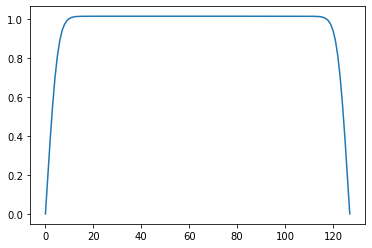

In [138]:
U = solve_U(128, 128, 0)
plt.plot(U[:,10])

U[:,-1]

In [30]:
class UNet(nn.Module):
    def __init__(
        self, 
        dtype, 
        img_size = 32, # pre-defined domain_size settings
        filters = 64, # number of filters
    ):
        super().__init__()
        self.image_size = img_size
        self.layers = int(np.log2(img_size)) # number of layers
        self.filters = filters
        self.dtype = dtype

        self.encoding_layers = nn.ModuleList()
        self.encoding_BN = nn.ModuleList()
        for i in range(self.layers):
            if i == 0:
                self.encoding_layers.append(nn.Conv2d(1, filters, kernel_size=4, stride=2, padding=1))
            else:
                self.encoding_layers.append(nn.Conv2d(min(2**(i-1),8)*filters, min(2**i, 8)*filters, kernel_size=4, stride=2, padding=1))
            self.encoding_BN.append(nn.BatchNorm2d(min(2**i*filters, 8*filters)))

        self.encoded = None
    
        self.decoding_layers = nn.ModuleList()
        self.decoding_BN = nn.ModuleList()

        for i in range(self.layers)[::-1]:
            if i == self.layers-1:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters, 8*filters), min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            elif i == 0:
                self.decoding_layers.append(nn.ConvTranspose2d(filters*2, 1, kernel_size=4, stride=2, padding=1))
            else:
                self.decoding_layers.append(nn.ConvTranspose2d(min(2**i*filters,8*filters)*2, min(2**(i-1)*filters, 8*filters), kernel_size=4, stride=2, padding=1))
            self.decoding_BN.append(nn.BatchNorm2d(min(max(2**(i-1),1)*filters, 8*filters)))

        self.bd = torch.zeros(1,1,img_size,img_size)
        self.bd[:,:,:,0] = 1
        self.bd[:,:,0,:] = 1
        self.bd[:,:,1:-1,-1] = 0
        self.bd[:,:,-1,:] = 1
    
        self.bd = self.bd.type(dtype)

    def forward(self, x, isNeum=[False, False, False, False]):
        ini_state = x
        x_copy = []
        for i in range(self.layers):
            if i == 0:
                x = F.leaky_relu(self.encoding_layers[i](x), 0.2)
            elif i == self.layers - 1:
                x = self.encoding_layers[i](x)
            else:
                x = F.leaky_relu(self.encoding_BN[i](self.encoding_layers[i](x)), 0.2)
            x_copy.append(x)
        self.encoded = x_copy.pop(-1)
        
        for i in range(self.layers):
            if i == 0:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(x)))
            elif i == self.layers - 1:
                x = torch.tanh(self.decoding_layers[i](F.relu(torch.cat((x,x_copy[0]), dim=1))))
            else:
                x = self.decoding_BN[i](self.decoding_layers[i](F.relu(torch.cat((x,x_copy[-1*i]), dim=1))))
#         nmbc = 0 * x
#         nmbc[:,:,:,0:2] = 1
#         nmbc[:,:,0:2,:] = 1
#         nmbc[:,:,:,-2:] = 1
#         nmbc[:,:,-2:,:] = 1
#         nmbc[:,:,1:-1,1:-1] = 0
            
        T_results = (x + 1) * 0.8 # x belongs to [-1,1]
        fixed_values = nmbc
#         return T_results * (1 - fixed_values) + ini_state * fixed_values
        return T_results * (1 - self.bd) + ini_state * self.bd

In [152]:
def conv_loss():
    "convolutional loss function based on steady heat equation"
    eclipic_K = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]]).type(dtype)
    adv_k = torch.tensor([[[[-1/2, 0, 1/2]]]]).type(dtype)
    def loss(U):
        Us = U**2
        return (1/h * F.conv1d(Us[:,:,1:-1,0:], adv_k) + 1/RE * 1/h**2 * F.conv2d(U, eclipic_K) - P).mean()
    return loss

In [139]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
dtype
U = torch.from_numpy(U).unsqueeze(0).unsqueeze(0).type(dtype)

In [141]:
U.type(dtype)

tensor([[[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 0.6608, 0.4806,  ..., 0.0807, 0.0806, 0.0805],
          [1.0000, 0.8900, 0.7719,  ..., 0.1589, 0.1587, 0.1585],
          ...,
          [1.0000, 0.8900, 0.7719,  ..., 0.1589, 0.1587, 0.1585],
          [1.0000, 0.6608, 0.4806,  ..., 0.0807, 0.0806, 0.0805],
          [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

In [143]:
U0 = torch.zeros(128)
U0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [161]:
eclipic_K = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]]).type(dtype)
eclipic_K_rhs = torch.tensor([[[[0, 0, -1], [-1, 2, 1], [0, 0, -1]]]]).type(dtype)

adv_k = torch.tensor([[[[-1/2, 0, 1/2]]]]).type(dtype)
adv_k_rhs = torch.tensor([[[[1/2, -2, 3/2]]]]).type(dtype)

Us = U**2
RE = 200
P = 0.2
size = 128
h = 1 / (size - 1)

loss = (1/h * F.conv1d(Us[:,:,1:-1,0:], adv_k) + 1/RE * 1/h**2 * F.conv2d(U, eclipic_K) - P).mean()
get_loss = conv_loss()
U = U.requires_grad_(True).type(dtype)
get_loss(U)

tensor(0.0520, grad_fn=<MeanBackward1>)

In [182]:
RHS = U[:,:,:,-3:]
# print(RHS)
rhsloss = F.conv2d(RHS, eclipic_K_rhs)
uloss = F.conv2d(U, eclipic_K)
print(uloss[:,:,:,-3:])
print(rhsloss.size())
biggg = torch.cat((uloss,rhsloss), dim = 3)

tensor([[[[2.4922e-03, 2.4919e-03, 2.4917e-03],
          [2.5279e-03, 2.5268e-03, 2.5259e-03],
          [2.5856e-03, 2.5833e-03, 2.5811e-03],
          [2.6630e-03, 2.6591e-03, 2.6553e-03],
          [2.7573e-03, 2.7514e-03, 2.7456e-03],
          [2.8644e-03, 2.8563e-03, 2.8484e-03],
          [2.9793e-03, 2.9687e-03, 2.9586e-03],
          [3.0961e-03, 3.0835e-03, 3.0710e-03],
          [3.2086e-03, 3.1937e-03, 3.1791e-03],
          [3.3097e-03, 3.2929e-03, 3.2766e-03],
          [3.3926e-03, 3.3746e-03, 3.3569e-03],
          [3.4511e-03, 3.4322e-03, 3.4140e-03],
          [3.4798e-03, 3.4612e-03, 3.4423e-03],
          [3.4753e-03, 3.4570e-03, 3.4391e-03],
          [3.4348e-03, 3.4178e-03, 3.4009e-03],
          [3.3582e-03, 3.3433e-03, 3.3283e-03],
          [3.2471e-03, 3.2344e-03, 3.2215e-03],
          [3.1042e-03, 3.0944e-03, 3.0842e-03],
          [2.9346e-03, 2.9269e-03, 2.9200e-03],
          [2.7426e-03, 2.7385e-03, 2.7341e-03],
          [2.5350e-03, 2.5336e-03, 2.531

In [180]:
biggg[:,:,:,-3:]

tensor([[[[2.4919e-03, 2.4917e-03, 2.4914e-03],
          [2.5268e-03, 2.5259e-03, 2.5249e-03],
          [2.5833e-03, 2.5811e-03, 2.5789e-03],
          [2.6591e-03, 2.6553e-03, 2.6516e-03],
          [2.7514e-03, 2.7456e-03, 2.7399e-03],
          [2.8563e-03, 2.8484e-03, 2.8405e-03],
          [2.9687e-03, 2.9586e-03, 2.9485e-03],
          [3.0835e-03, 3.0710e-03, 3.0587e-03],
          [3.1937e-03, 3.1791e-03, 3.1648e-03],
          [3.2929e-03, 3.2766e-03, 3.2605e-03],
          [3.3746e-03, 3.3569e-03, 3.3394e-03],
          [3.4322e-03, 3.4140e-03, 3.3956e-03],
          [3.4612e-03, 3.4423e-03, 3.4242e-03],
          [3.4570e-03, 3.4391e-03, 3.4212e-03],
          [3.4178e-03, 3.4009e-03, 3.3844e-03],
          [3.3433e-03, 3.3283e-03, 3.3134e-03],
          [3.2344e-03, 3.2215e-03, 3.2089e-03],
          [3.0944e-03, 3.0842e-03, 3.0739e-03],
          [2.9269e-03, 2.9200e-03, 2.9126e-03],
          [2.7385e-03, 2.7341e-03, 2.7293e-03],
          [2.5336e-03, 2.5318e-03, 2.530

In [124]:
F.conv1d(Us[:,:,1:-1,0:], adv_k)

tensor([[[[-0.0522, -0.0854, -0.0820,  ..., -0.0065, -0.0065, -0.0065],
          [-0.5901, -0.4263, -0.3333,  ..., -0.0252, -0.0252, -0.0251],
          [-0.8448, -0.7203, -0.6142,  ..., -0.0550, -0.0549, -0.0547],
          ...,
          [-0.8448, -0.7203, -0.6142,  ..., -0.0550, -0.0549, -0.0547],
          [-0.5901, -0.4263, -0.3333,  ..., -0.0252, -0.0252, -0.0251],
          [-0.0522, -0.0854, -0.0820,  ..., -0.0065, -0.0065, -0.0065]]]])